# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [1]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [37]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [ ]:
example_document = index.document(index.document_base())
print(example_document)

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [ ]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [ ]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [ ]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [ ]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [2]:
import collections
import io
import logging
import sys
from pprint import pprint

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)
            topic_id = int(topic_id)
            
            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    pprint(parse_topics([f_topics]))

OrderedDict([(51, 'Airbus Subsidies'),
             (52, 'South African Sanctions'),
             (53, 'Leveraged Buyouts'),
             (54, 'Satellite Launch Contracts'),
             (55, 'Insider Trading'),
             (56, 'Prime (Lending) Rate Moves, Predictions'),
             (57, 'MCI'),
             (58, 'Rail Strikes'),
             (59, 'Weather Related Fatalities'),
             (60, 'Merit-Pay vs. Seniority'),
             (61, 'Israeli Role in Iran-Contra Affair'),
             (62, "Military Coups D'etat"),
             (63, 'Machine Translation'),
             (64, 'Hostage-Taking'),
             (65, 'Information Retrieval Systems'),
             (66, 'Natural Language Processing'),
             (67, 'Politically Motivated Civil Disturbances'),
             (68, 'Health Hazards from Fine-Diameter Fibers'),
             (69, 'Attempts to Revive the SALT II Treaty'),
             (70, 'Surrogate Motherhood'),
             (71, 'Border Incursions'),
             (72, '

In [3]:
# Pyndri has a massive memory leak on my version so I gotta do this

import pyndri
import pickle
import time

start_time = time.time()

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])
index = pyndri.Index('index/')
dictionary = pyndri.extract_dictionary(index)
num_documents = index.maximum_document() - index.document_base()

index_copy = {}

print('{:.1f}s: Loading cached copy of pyndri index if available'.format(time.time() - start_time))
try:
    with open('index_copy.pickle', 'rb') as f:
        index_copy = pickle.load(f)
    print('{:.1f}s: Loaded cached copy of pyndri index'.format(time.time() - start_time))
except:
    print('{:.1f}s: Nope. Copying index'.format(time.time() - start_time))
    for document_id in range(index.document_base(), index.maximum_document()):
        index_copy[document_id] = index.document(document_id)
    with open('index_copy.pickle', 'wb') as f:
        pickle.dump(index_copy, f, pickle.HIGHEST_PROTOCOL)
    print('{:.1f}s: Finished and saved a copy of pyndri index'.format(time.time() - start_time))
    

1.1s: Loading cached copy of pyndri index if available
14.4s: Loaded cached copy of pyndri index


### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [6]:
import time
start_time = time.time()



tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)
tokenized_queries
total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index_copy[int_doc_id]

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 29.425861120224 seconds.


In [6]:
external2int = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, _ = index_copy[int_doc_id]
    external2int[ext_doc_id] = int_doc_id

In [4]:
import time


def run_retrieval(model_name, score_fn, parameter = None):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    
    data = {}
    
    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)

    with open('./ap_88_89/topics_title', 'r') as f_topics:
        query_list = parse_topics([f_topics])
        
    for query, sentence in query_list.items():
        print('{:.1f}s: {}'.format(time.time() - retrieval_start_time, query))
        query_ids = [dictionary.token2id.get(word,0) for word in index.tokenize(sentence) if(dictionary.token2id.get(word,0) > 0)]

        document_scores = []
        for document_id in range(index.document_base(), index.maximum_document()):
            if document_lengths[document_id] > 0:
                document = index_copy[document_id]
                score = score_fn(document_id, query_ids)
                document_scores.append((score, document[0]))

        sorted(document_scores, reverse = True)
        data[query] = document_scores               
        

    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

#run_retrieval('BM25', BM25)

In [7]:
# baseline metrics with random sorting
# update: it just scores only zeroes, but good to know
import random
def random_score (int_document_id, query_term_ids):
    return random.random()

run_retrieval('random', random_score)

Retrieving using random
0.0s: 51
1.0s: 52
1.9s: 53
2.8s: 54
3.9s: 55
4.8s: 56
5.7s: 57
6.6s: 58
7.5s: 59
8.4s: 60
9.3s: 61
10.2s: 62
11.1s: 63
12.0s: 64
12.8s: 65
13.7s: 66
14.6s: 67
15.5s: 68
16.4s: 69
17.3s: 70
18.2s: 71
19.1s: 72
20.0s: 73
20.9s: 74
21.8s: 75
22.6s: 76
23.6s: 77
24.5s: 78
25.4s: 79
26.3s: 80
27.2s: 81
28.1s: 82
29.0s: 83
29.9s: 84
30.9s: 85
31.8s: 86
32.7s: 87
33.6s: 88
34.5s: 89
35.4s: 90
36.3s: 91
37.1s: 92
38.0s: 93
38.9s: 94
39.8s: 95
40.7s: 96
41.6s: 97
42.5s: 98
43.4s: 99
44.3s: 100
45.1s: 101
46.1s: 102
47.0s: 103
47.9s: 104
48.8s: 105
49.7s: 106
50.5s: 107
51.4s: 108
52.3s: 109
53.2s: 110
54.1s: 111
55.0s: 112
55.9s: 113
56.8s: 114
57.7s: 115
58.6s: 116
59.5s: 117
60.4s: 118
61.3s: 119
62.4s: 120
63.4s: 121
64.4s: 122
65.3s: 123
66.3s: 124
67.2s: 125
68.1s: 126
69.0s: 127
69.9s: 128
70.8s: 129
71.7s: 130
72.9s: 131
73.8s: 132
74.7s: 133
75.6s: 134
76.5s: 135
77.4s: 136
78.2s: 137
79.1s: 138
80.1s: 139
81.0s: 140
81.9s: 141
82.8s: 142
83.7s: 143
84.6s: 144
85

### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [5]:
# Training the Gensim word2vec model ourselves for 5 epochs, like in the example
# code. This process took about 90 minutes, so we pickled the final model (250MB)
# and provide it in our submission.

import copy
import pyndri
import pyndri.compat
import sys
import time
from gensim import corpora, models, similarities
import pickle


start_time = time.time()

print('{:.1f}s: Converting to IndriSentences'.format(time.time() - start_time))
sentences = pyndri.compat.IndriSentences(index, dictionary)

# print('{:.1f}s: Test IndriSentences'.format(time.time() - start_time))
# for i, doc in enumerate(sentences):
#     if i>=3:
#         break
#     print(doc)

is_model_trained_already = False
print('{:.1f}s: Loading cached Gensim word2vec model if available'.format(time.time() - start_time))
try:
    with open('trained_word2vec_after_5_epoch.pickle', 'rb') as f:
        gensim_embeddings = pickle.load(f).wv
    print('{:.1f}s: Loaded cached gensim word2vec model'.format(time.time() - start_time))
    is_model_trained_already = True
except:
    print('{:.1f}s: Nope'.format(time.time() - start_time))


if not is_model_trained_already:
    print('{:.1f}s: Starting process of training model (est. 90 minutes total)'.format(time.time() - start_time))
    print('{:.1f}s: Building vocab (estimated 220 seconds)'.format(time.time() - start_time))
    word2vec_init = gensim.models.Word2Vec(
        size=300,  # Embedding size
        window=5,  # One-sided window size
        sg=True,  # Skip-gram.
        min_count=5,  # Minimum word frequency.
        sample=1e-3,  # Sub-sample threshold.
        hs=False,  # Hierarchical softmax.
        negative=10,  # Number of negative examples.
        iter=1,  # Number of iterations.
        workers=8,  # Number of workers.
    )
    word2vec_init.build_vocab(sentences, trim_rule=None)
    
    print('{:.1f}s: Training word2vec'.format(time.time() - start_time))
    model = word2vec_init
    del word2vec_init
    for epoch in range(1, 5 + 1):
        print('{:.1f}s: start epoch {} of 5 (estimated 1000 seconds)'.format(time.time() - start_time, epoch))
        model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
        print('{:.1f}s: Saving model {} to pickle file'.format(time.time() - start_time, epoch))
        with open('trained_word2vec_after_{}_epoch.pickle'.format(epoch), 'wb') as f:
            pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
    
    print('{:.1f}s: Finished training word2vec model'.format(time.time() - start_time))
    gensim_embeddings = model.wv
    del model
    
print('{:.1f}s: Done for now'.format(time.time() - start_time))
del sentences

0.0s: Converting to IndriSentences
0.0s: Loading cached Gensim word2vec model if available
4.1s: Loaded cached gensim word2vec model
4.1s: Done for now


In [4]:
# load the google word2vec model

from gensim.models.keyedvectors import KeyedVectors
google_embeddings = KeyedVectors.load_word2vec_format('reduced_vectors_google.txt', binary=False)

In [60]:
from pprint import pprint
word = 'vacation'
pprint(google_embeddings.similar_by_word(word))
pprint(gensim_embeddings.similar_by_word(word))
# Google is more accurate, but gensim seems at least alright

[('vacations', 0.8465889692306519),
 ('vacationing', 0.7091163396835327),
 ('vaction', 0.6794564723968506),
 ('getaways', 0.618423342704773),
 ('honeymoon', 0.6129909157752991),
 ('holidays', 0.6012001037597656),
 ('vacationed', 0.5707447528839111),
 ('vacationers', 0.5669425129890442),
 ('getaway', 0.5532756447792053),
 ('holiday', 0.5512028932571411)]
[('vacations', 0.7073043584823608),
 ('kennebunkport', 0.5963935852050781),
 ('vacationed', 0.5364298820495605),
 ('vacationing', 0.5339806079864502),
 ('holidays', 0.5285091400146484),
 ('oceanside', 0.5270141363143921),
 ('trip', 0.525744616985321),
 ('jaunts', 0.5229578018188477),
 ('begrudges', 0.5171878933906555),
 ('trips', 0.5128523111343384)]


In [6]:
# pre-calculate the df scores for each word (basically a reverse index for all words, not just query words)

from collections import defaultdict
import numpy as np

import time
start_time = time.time()


print('{:.1f}s: Calculating extended inverse index'.format(time.time() - start_time))

docs_per_word = defaultdict(set)
for doc_id in np.arange(index.document_base(), index.maximum_document()):
    doc = index_copy[doc_id]
    for word_id in doc[1]:
        docs_per_word[word_id].add(doc_id)

df_per_word = defaultdict(int)
for word_id, docs in docs_per_word.items():
    df_per_word[word_id] = len(docs)
del docs_per_word
print('{:.1f}s: Done for now'.format(time.time() - start_time))


0.0s: Calculating extended inverse index
78.1s: Done for now


In [7]:
import numpy as np

# build document or query embedding by averaging the word embedding
def get_average_word_embedding (bow_of_input, embeddings, use_tfidf_weights=False):
    #embedding_size = embeddings.vector_size # doesn't work for gensim trained model ???
    embedding_size = embeddings[embeddings.index2word[0]].size
    total_embedding = np.zeros(embedding_size)
    for token_id, count in bow_of_input.items():
        word = dictionary.id2token[token_id]
        if not word in embeddings.vocab:
            continue
        embedding = embeddings[word]
        if use_tfidf_weights: # weigh each word by its discriminative power
            tf = 1 + np.log(bow_of_input.get(token_id, 1)) # log normalized
            df = df_per_word[token_id]
            if df == 0:
                weight = 0.0
            else:
                idf = num_documents / df
                weight = tf*idf
        else:
            weight = count # just simple average
        total_embedding += np.array(weight * embedding)
    total_embedding /= len(bow_of_input)
    return total_embedding

In [16]:
#example
query_id = 70
print('query:', queries[query_id])
query_bow = collections.Counter(
        token_id for token_id in tokenized_queries[query_id]
        if token_id > 0)
print('query as BOW:', query_bow)
query_embedding = get_average_word_embedding(query_bow, gensim_embeddings)
print('query embedding (gensim):', type(query_embedding), query_embedding.shape)
print(query_embedding[:5], '...')
query_embedding = get_average_word_embedding(query_bow, gensim_embeddings, use_tfidf_weights=True)
print('query embedding (gensim, weighted):', type(query_embedding), query_embedding.shape)
print(query_embedding[:5], '...')

query: Surrogate Motherhood
query as BOW: Counter({233033: 1, 163926: 1})
query embedding (gensim): <class 'numpy.ndarray'> (300,)
[-0.10624129 -0.19719909  0.01255816  0.01103399 -0.11671718] ...
query embedding (gensim, weighted): <class 'numpy.ndarray'> (300,)
[-151.10468292 -295.35044861  -25.09288025   17.34195423 -177.32430077] ...


# Document embeddings
We came up with 2 ideas to improve the 'standard' approach in constructing representations of queries and documents using word embeddings. The standard approach refers to the average embedding of each word in the query or document. Inspired by [paper https://arxiv.org/pdf/1707.02377.pdf end of introduction], we considered the TF-IDF scores as weights in the summation of each word embedding in a query or document. Inspired by a comment in the lecture (that simple averaging doesn't work well for long documents), we also split documents into overlapping parts of M (100) words. Applying/not applying these ideas resulted in 4 models.

In [42]:
# collect all document embeddings (estimated 70 minutes)
import math
import time
start_time = time.time()

num_documents = index.maximum_document() - index.document_base()

print('{:.1f}s: Collecting all document embeddings'.format(time.time() - start_time))

doc_embeddings_simple = {}
doc_embeddings_weighted = {}
doc_embeddings_simple_split = {}
doc_embeddings_weighted_split = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    if int_doc_id % 1000 == 0:
        print('{:.1f}s: {} out of {}'.format(time.time() - start_time, int_doc_id, index.maximum_document()))
    ext_doc_id, doc_token_ids = index_copy[int_doc_id]

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    
    doc_embeddings_simple[int_doc_id] = get_average_word_embedding(document_bow, gensim_embeddings)
    doc_embeddings_weighted[int_doc_id] = get_average_word_embedding(document_bow, gensim_embeddings, True)
    
    # split document into parts of M words and represent each part as a separate embedding
    doc_embeddings_simple_split[int_doc_id] = []
    doc_embeddings_weighted_split[int_doc_id] = []
    M = 100
    chunk_count = math.ceil(len(doc_token_ids)/M)
    chunks = []
    for i in range(chunk_count):
        chunks.append(doc_token_ids[i*M:(i+1)*M])
        if i < chunk_count - 1:
            offset = int(M/2)
            chunks.append(doc_token_ids[offset+i*M:offset+(i+1)*M])
    
    for chunk in chunks:
        chunk_bow = collections.Counter(
            token_id for token_id in chunk
            if token_id > 0)
        if len(chunk_bow) <= 0:
            continue
        doc_embeddings_simple_split[int_doc_id].append(get_average_word_embedding(chunk_bow, gensim_embeddings))
        doc_embeddings_weighted_split[int_doc_id].append(get_average_word_embedding(chunk_bow, gensim_embeddings, True))
print('{:.1f}s: Done for now'.format(time.time() - start_time))

0.0s: Collecting all document embeddings
10.1s: 1000 out of 164598
20.0s: 2000 out of 164598
29.5s: 3000 out of 164598
38.8s: 4000 out of 164598
47.5s: 5000 out of 164598
56.2s: 6000 out of 164598
65.6s: 7000 out of 164598
74.5s: 8000 out of 164598
85.3s: 9000 out of 164598
94.1s: 10000 out of 164598
103.4s: 11000 out of 164598
112.1s: 12000 out of 164598
121.5s: 13000 out of 164598
130.2s: 14000 out of 164598
139.0s: 15000 out of 164598
148.2s: 16000 out of 164598
157.1s: 17000 out of 164598
166.0s: 18000 out of 164598
175.3s: 19000 out of 164598
184.6s: 20000 out of 164598
193.5s: 21000 out of 164598
202.1s: 22000 out of 164598
211.3s: 23000 out of 164598
220.3s: 24000 out of 164598
229.0s: 25000 out of 164598
238.1s: 26000 out of 164598
246.9s: 27000 out of 164598
255.9s: 28000 out of 164598
265.7s: 29000 out of 164598
274.5s: 30000 out of 164598
283.6s: 31000 out of 164598
292.8s: 32000 out of 164598
302.0s: 33000 out of 164598
311.2s: 34000 out of 164598
320.5s: 35000 out of 16459

In [ ]:
# save em just to be sure

with open('safetyfuck.pickle', 'wb') as f:
    pickle.dump((doc_embeddings_simple,doc_embeddings_weighted, doc_embeddings_simple_split, doc_embeddings_weighted_split), f, pickle.HIGHEST_PROTOCOL)


In [165]:
# example of how chunks of documents are subdivided

doc_token_ids = list(range(73))

M = 10
chunk_count = math.ceil(len(doc_token_ids)/M)
chunks = []
for i in range(chunk_count):
    chunks.append(doc_token_ids[i*M:(i+1)*M])
    if i < chunk_count - 1:
        offset = int(M/2)
        chunks.append(doc_token_ids[offset+i*M:offset+(i+1)*M])
pprint(chunks)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [55, 56, 57, 58, 59, 60, 61, 62, 63, 64],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [65, 66, 67, 68, 69, 70, 71, 72],
 [70, 71, 72]]


In [43]:
from scipy import spatial

def simple_embeddings_gensim (int_document_id, query_term_ids):
    query_bow = collections.Counter(
        token_id for token_id in query_term_ids
        if token_id > 0)
    query_embedding = get_average_word_embedding(query_bow, gensim_embeddings)
    doc_embedding = doc_embeddings_simple[int_document_id]
    cosine_similarity = 1 - spatial.distance.cosine(query_embedding, doc_embedding)
    return cosine_similarity


def weighted_embeddings_gensim (int_document_id, query_term_ids):
    query_bow = collections.Counter(
        token_id for token_id in query_term_ids
        if token_id > 0)
    query_embedding = get_average_word_embedding(query_bow, gensim_embeddings, True)
    doc_embedding = doc_embeddings_weighted[int_document_id]
    cosine_similarity = 1 - spatial.distance.cosine(query_embedding, doc_embedding)
    return cosine_similarity


def simple_split_embeddings_gensim (int_document_id, query_term_ids):
    query_bow = collections.Counter(
        token_id for token_id in query_term_ids
        if token_id > 0)
    query_embedding = get_average_word_embedding(query_bow, gensim_embeddings)
    doc_embeddings = doc_embeddings_simple_split[int_document_id]
    cosine_similarity = max([1 - spatial.distance.cosine(query_embedding, doc_embedding) for doc_embedding in doc_embeddings])
    return cosine_similarity


def weighted_split_embeddings_gensim (int_document_id, query_term_ids):
    query_bow = collections.Counter(
        token_id for token_id in query_term_ids
        if token_id > 0)
    query_embedding = get_average_word_embedding(query_bow, gensim_embeddings, True)
    doc_embeddings = doc_embeddings_weighted_split[int_document_id]
    cosine_similarity = max([1 - spatial.distance.cosine(query_embedding, doc_embedding) for doc_embedding in doc_embeddings])
    return cosine_similarity

In [13]:
# test experiment
query = [2701, 1496, 420, 0, 25480] # words from document 1
print(len(index_copy[8][1]))
# print(index_copy[1])
print('on hit:')
print(simple_embeddings_gensim(1, query))
print(weighted_embeddings_gensim(1, query))
print(simple_split_embeddings_gensim(1, query))
print(weighted_split_embeddings_gensim(1, query))
print('on miss:')
print(simple_embeddings_gensim(8, query))
print(weighted_embeddings_gensim(8, query))
print(simple_split_embeddings_gensim(8, query))
print(weighted_split_embeddings_gensim(8, query))


800
on hit:
0.730520310599
0.823788059064
0.806145897762
0.925391343151
on miss:
0.600923433406
0.379962573991
0.607054587014
0.379922451188


In [16]:
# test nan
query_id = 51
query = tokenized_queries[query_id]
ext_doc_id = 'AP890425-0184'
int_doc_id = external2int[ext_doc_id]
print('ext_doc_id:', ext_doc_id, 'int_doc_id:', int_doc_id, 'query:', queries[query_id], 'tokens:', tokenized_queries[query_id])
_, doc_token_ids = index_copy[int_doc_id]
document_bow = collections.Counter(
    token_id for token_id in doc_token_ids
    if token_id > 0)
print(simple_embeddings_gensim(int_doc_id, query))
print(weighted_embeddings_gensim(int_doc_id, query))
print(simple_split_embeddings_gensim(int_doc_id, query))
print(weighted_split_embeddings_gensim(int_doc_id, query))

ext_doc_id: AP890425-0184 int_doc_id: 184 query: Airbus Subsidies tokens: [5872, 3066]
0.329753876868
0.187987433689
0.334746736647
0.192825132626


In [44]:
# run experiment
# run_retrieval('simple word2vec (gensim)', simple_embeddings_gensim)
# run_retrieval('weighted word2vec (gensim)', weighted_embeddings_gensim)
# run_retrieval('simple word2vec on document splits (gensim)', simple_split_embeddings_gensim)
run_retrieval('weighted word2vec on document splits (gensim)', weighted_split_embeddings_gensim) # 23 hours, be prepared

Retrieving using weighted word2vec on document splits (gensim)
0.0s: 51


/usr/local/lib/python3.5/dist-packages/scipy/spatial/distance.py:326: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


281.3s: 52
601.1s: 53
902.9s: 54
1219.0s: 55
1523.8s: 56
1832.5s: 57
2128.5s: 58
2475.0s: 59
2829.2s: 60
3150.3s: 61
3461.9s: 62
3767.2s: 63
4220.2s: 64
4638.8s: 65
4992.2s: 66
5416.9s: 67
8092.7s: 68
8558.0s: 69
9046.5s: 70
9485.0s: 71
9914.5s: 72
10363.2s: 73
10896.0s: 74
11399.0s: 75
11906.1s: 76
12469.9s: 77
13022.7s: 78
13576.6s: 79
14151.4s: 80
14702.4s: 81
15306.1s: 82
15963.2s: 83
16572.9s: 84
17214.0s: 85
17862.9s: 86
18483.7s: 87
19168.5s: 88
19825.2s: 89
20514.8s: 90
21158.1s: 91
21714.2s: 92
22262.8s: 93
22756.2s: 94
23272.4s: 95
23895.3s: 96
24549.5s: 97
25096.3s: 98
25644.1s: 99
26182.5s: 100
26701.0s: 101
27240.0s: 102
27787.4s: 103
28261.7s: 104
28797.8s: 105
29341.9s: 106
29870.4s: 107
30394.1s: 108
30919.1s: 109
31450.4s: 110
31993.3s: 111
32528.9s: 112
33102.9s: 113
33663.7s: 114
34240.1s: 115
34797.0s: 116
35377.0s: 117
35943.7s: 118
36522.3s: 119
37066.9s: 120
37587.3s: 121
38072.8s: 122
38570.3s: 123
39054.7s: 124
39544.9s: 125
40030.1s: 126
40510.4s: 127
41007.6s

In [ ]:
from scipy import stats
import itertools

def get_model_results (model_name, metrics):
    file = open(model_name + '.run.txt', 'r')  
    lines = file.readlines()
    scores = {'name':model_name}
    for metric in metrics:
        scores[metric] = {}
    for line in lines:
        metric, query_id, score = line.split()
        if not metric in metrics:
            continue
        if query_id == 'all':
            continue
        query_id = int(query_id)
        score = float(score)
        scores[metric][query_id] = score
    return scores


model_names = ['tfidf',
        'simple word2vec (gensim)',
         'weighted word2vec (gensim)',
         'simple word2vec on document splits (gensim)',
         'weighted word2vec on document splits (gensim)']
metrics = ['recall_1000', 'map_cut_1000', 'ndcg_cut_10', 'P_5']
model_results = [get_model_results(model_name, metrics) for model_name in model_names]

In [164]:
# significance testing

for model_result_pair in itertools.combinations(model_results, 2):
    model1, model2 = model_result_pair
    print(model1['name'], 'vs', model2['name'])
    for metric in metrics:
        a = list(model1[metric].values())
        b = list(model2[metric].values())
        t_stat, p_val = stats.ttest_rel(a, b)
        print('\t{:15s}'.format(metric), 't_stat:', t_stat, '\tp:', p_val)

simple word2vec (gensim) vs weighted word2vec (gensim)
	recall_1000     t_stat: -16.4861115012 	p: 1.63997245677e-32
	map_cut_1000    t_stat: -8.6055637578 	p: 3.65300001294e-14
	ndcg_cut_10     t_stat: -7.66991989597 	p: 5.20669583869e-12
	P_5             t_stat: -7.1700075171 	p: 6.86702110076e-11
simple word2vec (gensim) vs simple word2vec on document splits (gensim)
	recall_1000     t_stat: -29.7089890999 	p: 6.97185706795e-57
	map_cut_1000    t_stat: -12.2728061553 	p: 7.11246967217e-23
	ndcg_cut_10     t_stat: -11.2120674028 	p: 2.37016701362e-20
	P_5             t_stat: -9.95323129252 	p: 2.39517998374e-17
simple word2vec (gensim) vs weighted word2vec on document splits (gensim)
	recall_1000     t_stat: -16.4321146726 	p: 2.15309161932e-32
	map_cut_1000    t_stat: -8.64767390786 	p: 2.91295418458e-14
	ndcg_cut_10     t_stat: -6.03914064517 	p: 1.81531289501e-08
	P_5             t_stat: -5.29722901394 	p: 5.46850348275e-07
weighted word2vec (gensim) vs simple word2vec on document

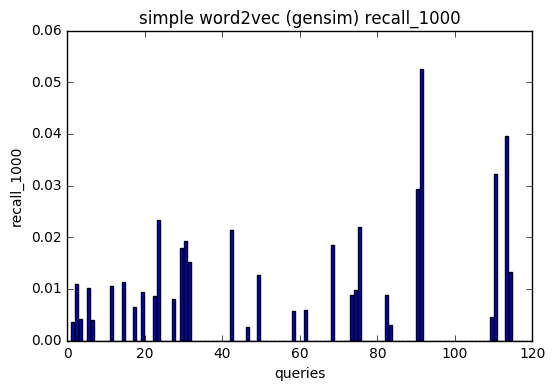

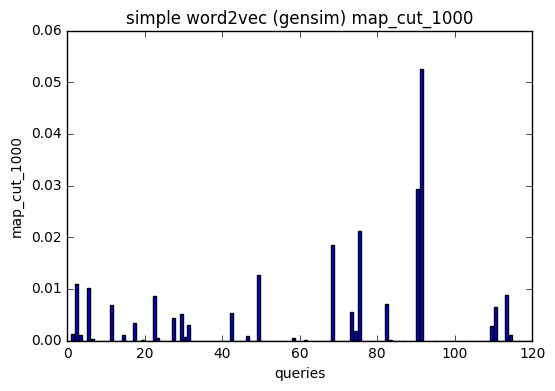

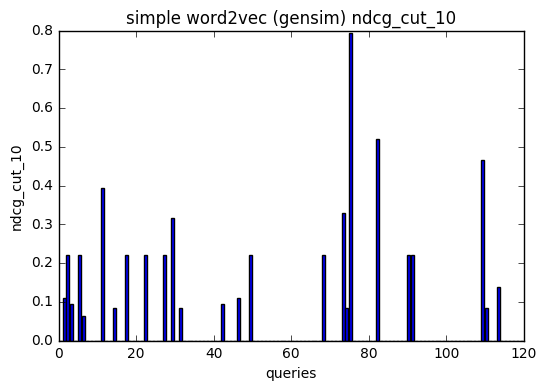

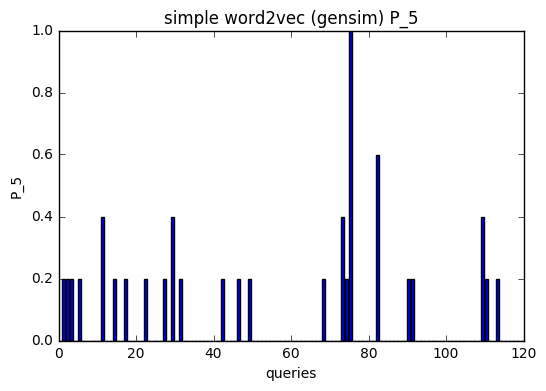

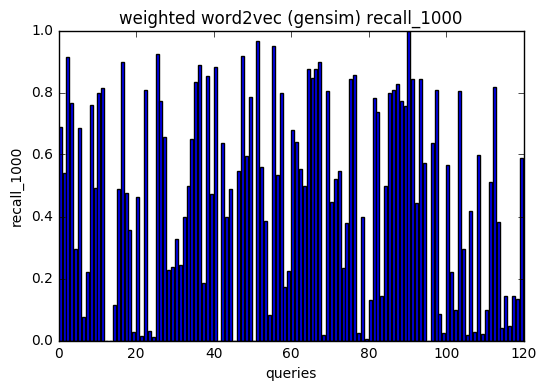

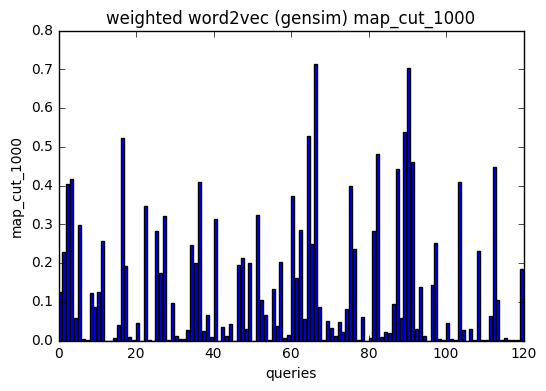

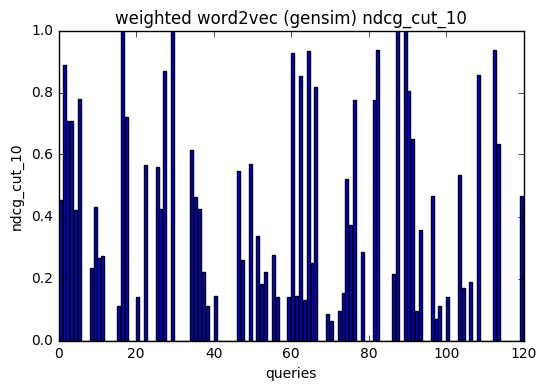

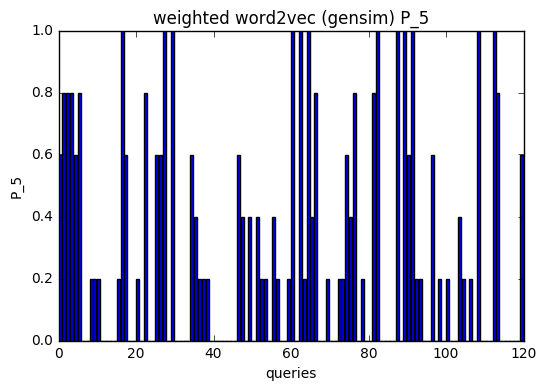

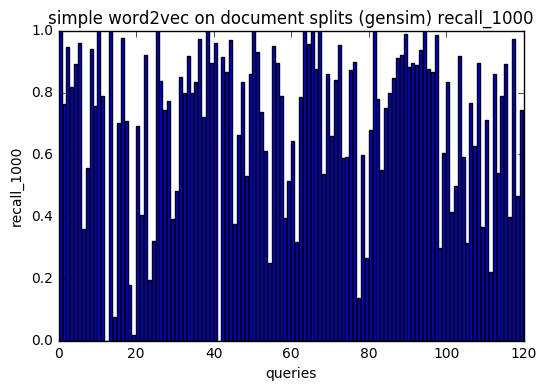

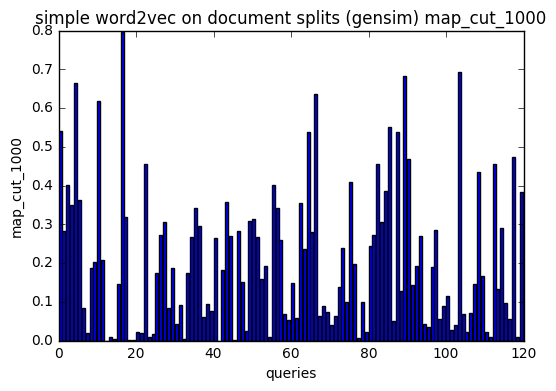

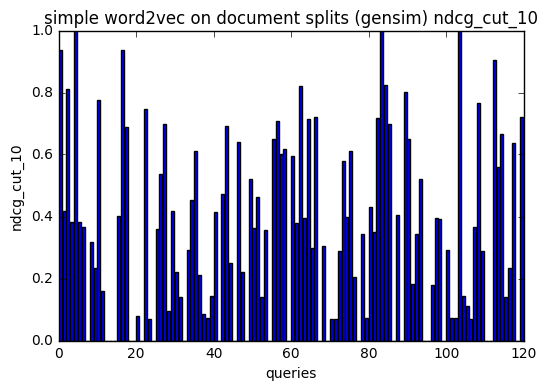

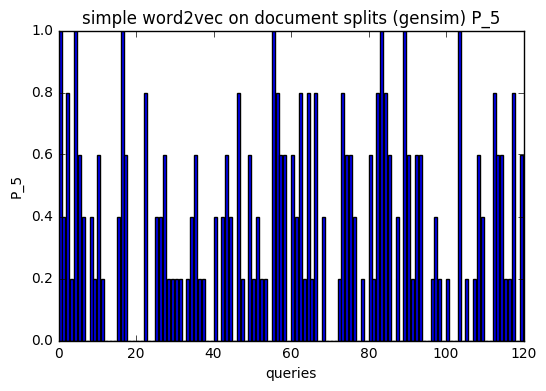

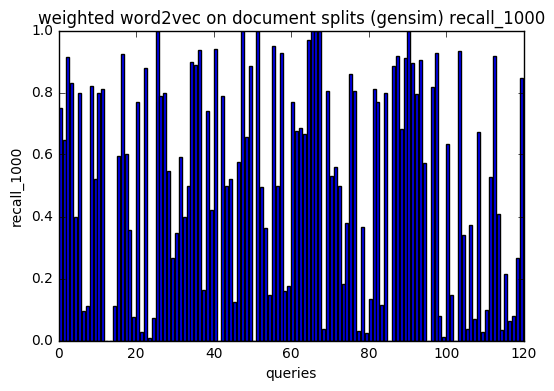

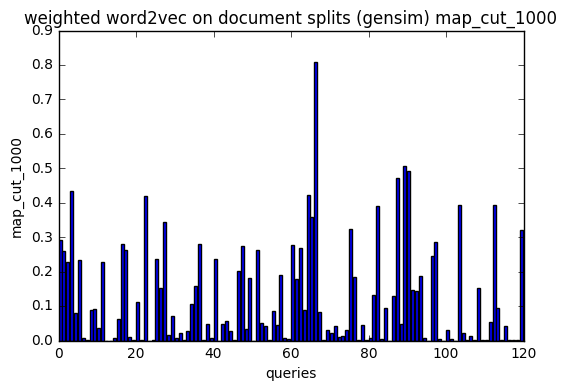

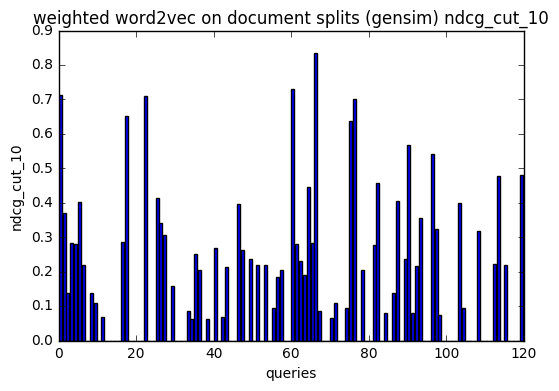

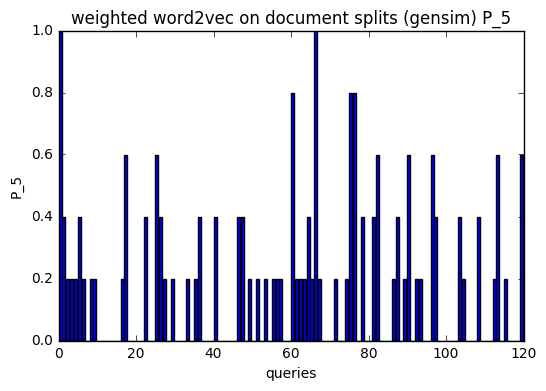

In [198]:
# plotting raw values to find interesting patterns. Nothing except lack of pattern was interesting

for i, model_result in enumerate(model_results):
    for j, metric in enumerate(metrics):
        
        y = model_result[metric].values()
    #     y = sorted(y, reverse=True)
        x = range(len(y))
        plt.bar(x, y, color="blue")

        plt.title(model_result['name'] + ' ' + metric)
        plt.xlabel('queries')
        plt.ylabel(metric)
        plt.show()

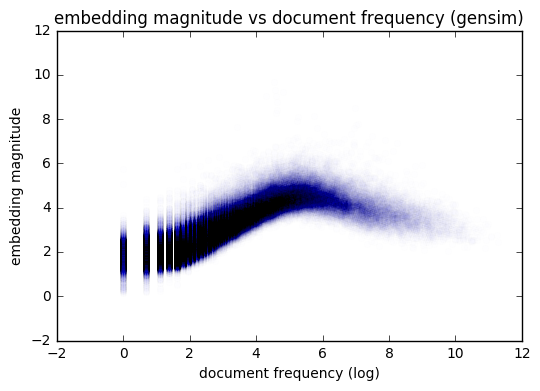

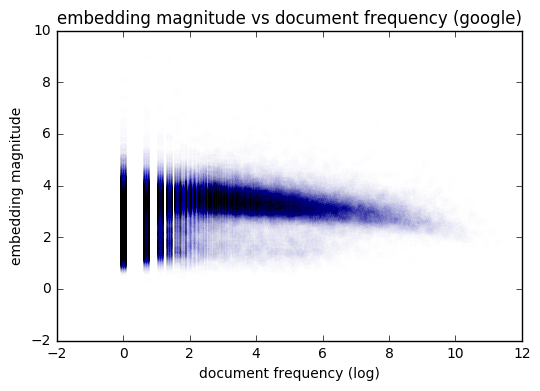

In [195]:
# see if there is a structural bias in gensim word embeddings

import numpy as np
def plot_norm_vs_df (embeddings, name):
    dfs = []
    magnitudes = []

    for word, df in df_per_word.items():
        try:
            magnitude = np.linalg.norm(embeddings[dictionary.id2token[word]])
            magnitudes.append(magnitude)
            dfs.append(np.log(df))
        except:
            ...
    title = 'embedding magnitude vs document frequency ({})'.format(name)
    plt.title(title)
    plt.scatter(dfs, magnitudes, alpha=0.005)
    plt.xlabel('document frequency (log)')
    plt.ylabel('embedding magnitude')
    plt.savefig(title+'.png')
    plt.show()

    
plot_norm_vs_df(gensim_embeddings, 'gensim')
plot_norm_vs_df(google_embeddings, 'google')